---
title: 04 - CellRank
date: 01-09-2023
author: Martin Proks
---

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [3]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [4]:
import scvelo as scv
scv.set_figure_params('scvelo')

In [5]:
adata = sc.read("../results/03_mouse.processed.h5ad")
adata

AnnData object with n_obs × n_vars = 2004 × 3000
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'batch_og', '_scvi_batch', '_scvi_labels', 'leiden', 'dpt_pseudotime', 't', 'seg', 'edge', 't_sd', 'milestones', 'draw_graph_fa_density_ct'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ct_colors', 'ct_sizes', 'dendro_segments', 'diffmap_evals', 'draw_graph', 'draw_graph_fa_density_ct_params', 'experiment_colors', 'graph', 'hvg', 'iroot', 'leiden', 'log1p', 'milestones_colors', 'neighbors', 'paga', 'pca', 'ppt', 'pseudotime_list', 'seg_colors', 'stage_colors', 'timepoint_colors', 'tsne', 'umap'
    obsm: 'X_R', '

2023-11-20 20:08:29.075804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


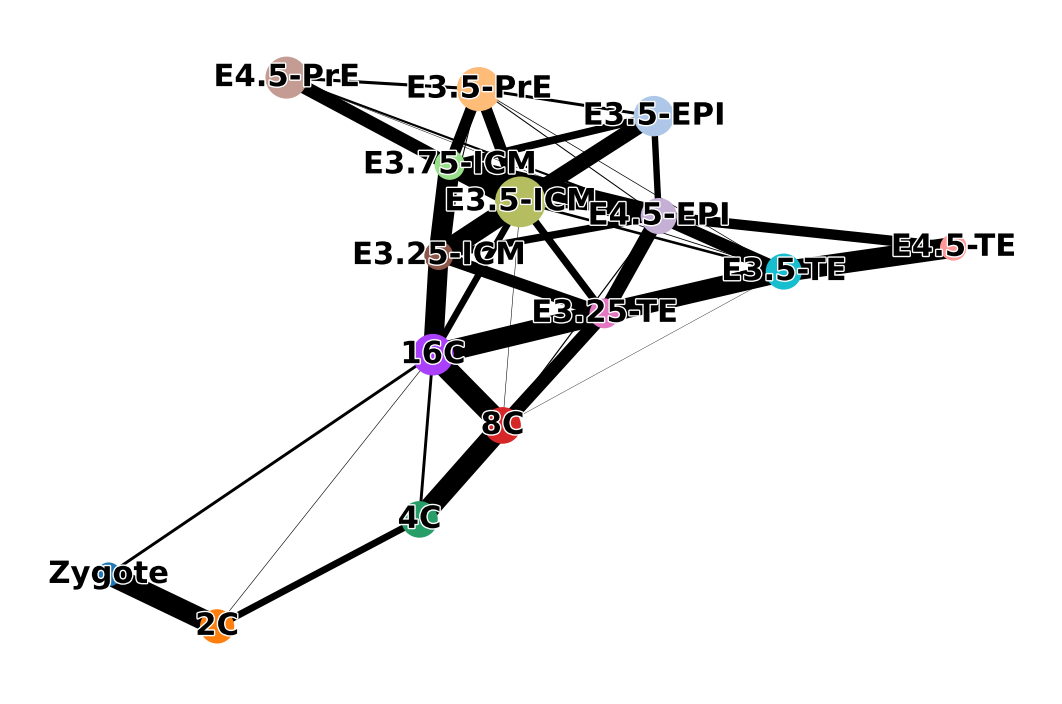

In [6]:
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.diffmap(adata)

sc.tl.paga(adata, groups='ct')
sc.pl.paga(adata, color=['ct'], frameon=False, fontoutline=True)
sc.tl.draw_graph(adata, init_pos='paga', n_jobs=10)

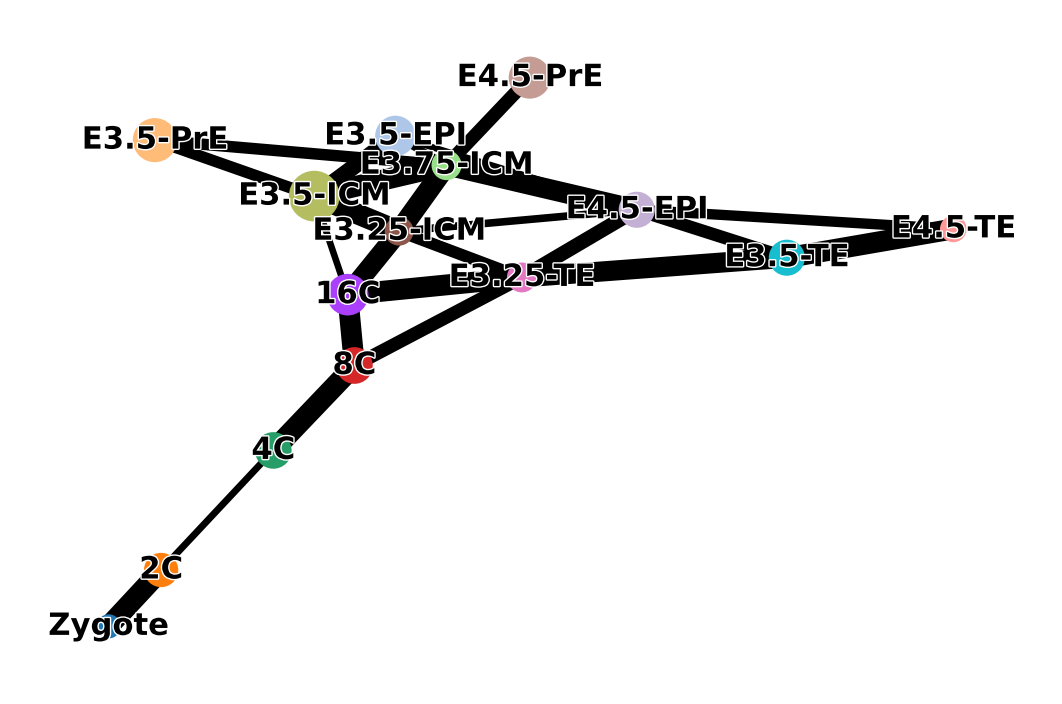

In [7]:
sc.pl.paga(adata, color=['ct'], frameon=False, fontoutline=True, threshold=0.2)

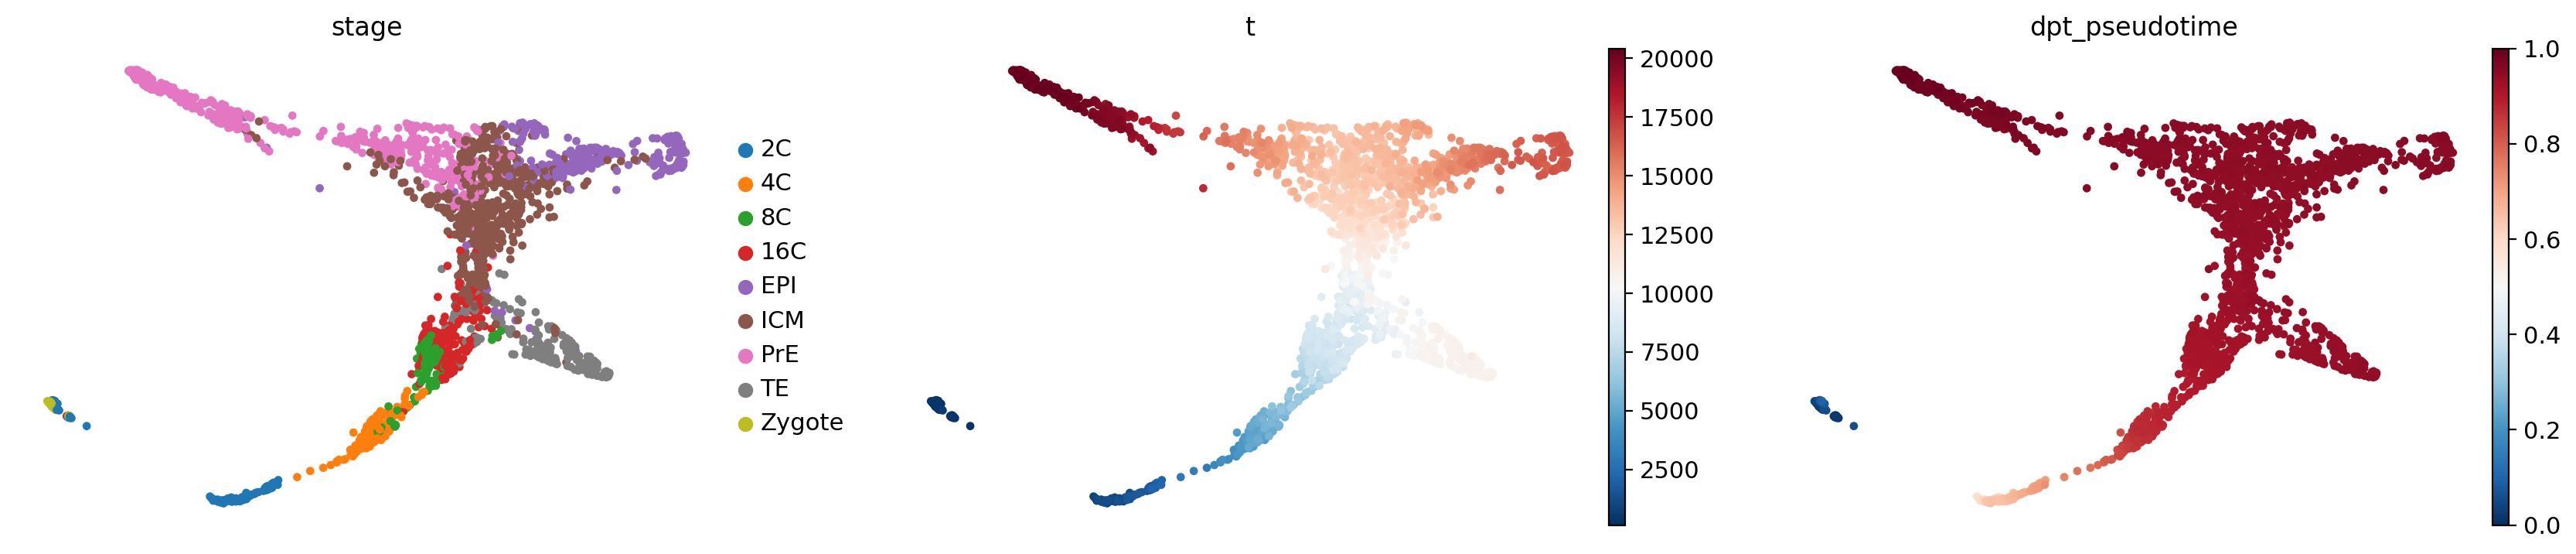

In [8]:
sc.pl.embedding(adata, basis="X_draw_graph_fa", color=["stage", "t", "dpt_pseudotime"])

## 1. PseudoKernel

In [ ]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="t")

In [ ]:
pk.compute_transition_matrix()

In [ ]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"stage": "Zygote"},
    basis="X_draw_graph_fa",
    legend_loc="right",
    dpi=150,
)

In [ ]:
pk.plot_projection(basis="X_draw_graph_fa", recompute=True, color='stage')

### Initial and Terminal states

In [ ]:
g = cr.estimators.GPCCA(pk)
print(g)

In [ ]:
g.fit(cluster_key="stage", n_states=[4, 12])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100, basis='X_draw_graph_fa')

In [ ]:
g.predict_terminal_states(n_states=3)
g.plot_macrostates(which="terminal", legend_loc="right", s=100, basis='X_draw_graph_fa')

In [ ]:
g.plot_macrostates(which="terminal", discrete=False, basis='X_draw_graph_fa')

In [ ]:
g.predict_initial_states(allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100, basis='X_draw_graph_fa')

In [ ]:
g.plot_coarse_T()

In [ ]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False, basis='X_draw_graph_fa')

In [ ]:
g.plot_fate_probabilities(same_plot=True, basis='X_draw_graph_fa', color=['red', 'green', 'blue', 'black'])

In [ ]:
g.compute_absorption_times()

In [ ]:
g.compute_lineage_drivers()

In [ ]:
g.absorption_times

## 2. RealtimeKernel

In [9]:
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem

In [10]:
adata.obs['cr_timepoint'] = adata.obs.timepoint.cat.rename_categories({
    'Zygote': 0.5,
    '2C': 1.5, 
    '4C': 2.0, 
    '8C': 2.5, 
    '16C': 3, 
    'E3.25': 3.25, 
    'E3.5': 3.5, 
    'E3.75': 3.75, 
    'E4.5': 4.5,
})

In [11]:
adata.obs.cr_timepoint.value_counts()

3.5     995
4.5     343
3.0     198
2.5     115
2.0     114
3.25     87
1.5      86
3.75     48
0.5      18
Name: cr_timepoint, dtype: int64

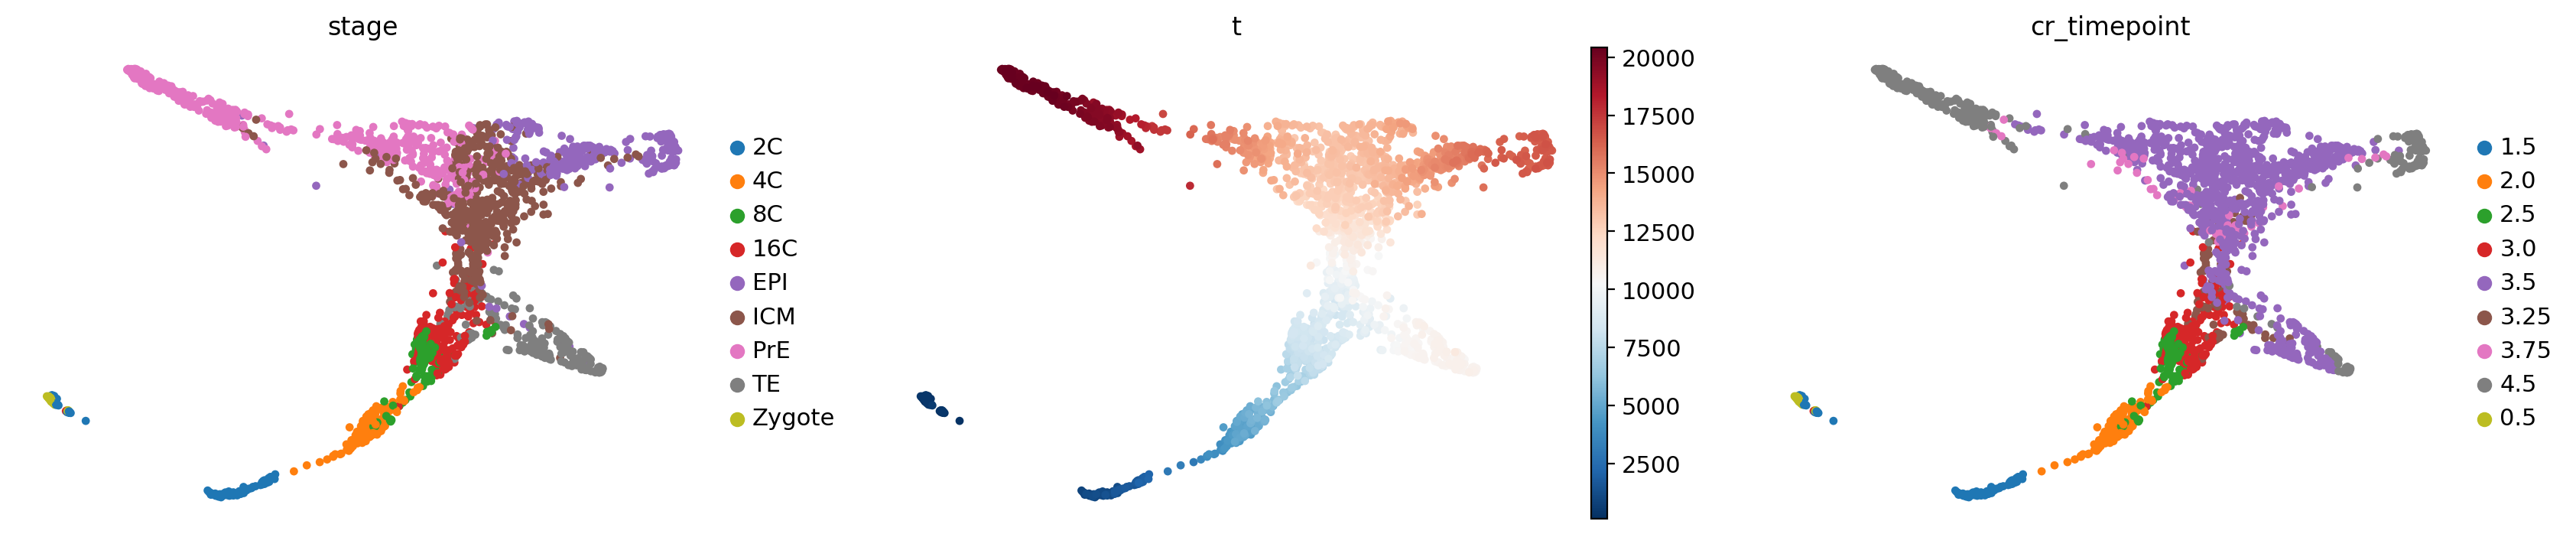

In [12]:
sc.pl.embedding(adata, basis="X_draw_graph_fa", color=["stage", "t", "cr_timepoint"])

In [131]:
adata_sub = adata[adata.obs.cr_timepoint != 0.5].copy()
adata_sub.obs.cr_timepoint.value_counts()
# adata_sub = adata.copy()

3.5     995
4.5     343
3.0     198
2.5     115
2.0     114
3.25     87
1.5      86
3.75     48
Name: cr_timepoint, dtype: int64

In [132]:
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub, random_state=0)

In [133]:
tp = TemporalProblem(adata_sub)

In [134]:
# tp = tp.prepare(time_key="cr_timepoint", joint_attr='X_scVI')
tp = tp.prepare(time_key="cr_timepoint")

INFO     Ordering Index(['SRX259148', 'SRX259191', 'SRX259121', 'SRX259140', 'SRX259161',                          
                'SRX259210', 'SRX259133', 'SRX259142', 'SRX259106', 'SRX386064',                                   
                ...                                                                                                
                'GSM2687789', 'GSM2687797', 'GSM2687761', 'GSM2687760', 'GSM2687841',                              
                'GSM2687771', 'GSM2687764', 'GSM2687837', 'GSM2687752', 'GSM2687839'],                             
               dtype='object', length=1986) in ascending order.                                                    
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`       

In [135]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `7` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(48, 343)].                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(115, 198)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(87, 48)].                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(995, 87)].                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(198, 995)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(114, 115)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(86, 114)].                                     


In [136]:
tmk = RealTimeKernel.from_moscot(tp)

In [137]:
tmk.compute_transition_matrix()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58254.22time pair/s]

Using automatic `threshold=2.4929099680338496e-42`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


RealTimeKernel[n=1986, threshold='auto', self_transitions='connectivities']

Simulating `100` random walks of maximum length `500`


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.52sim/s]


    Finish (0:00:07)
Plotting random walks


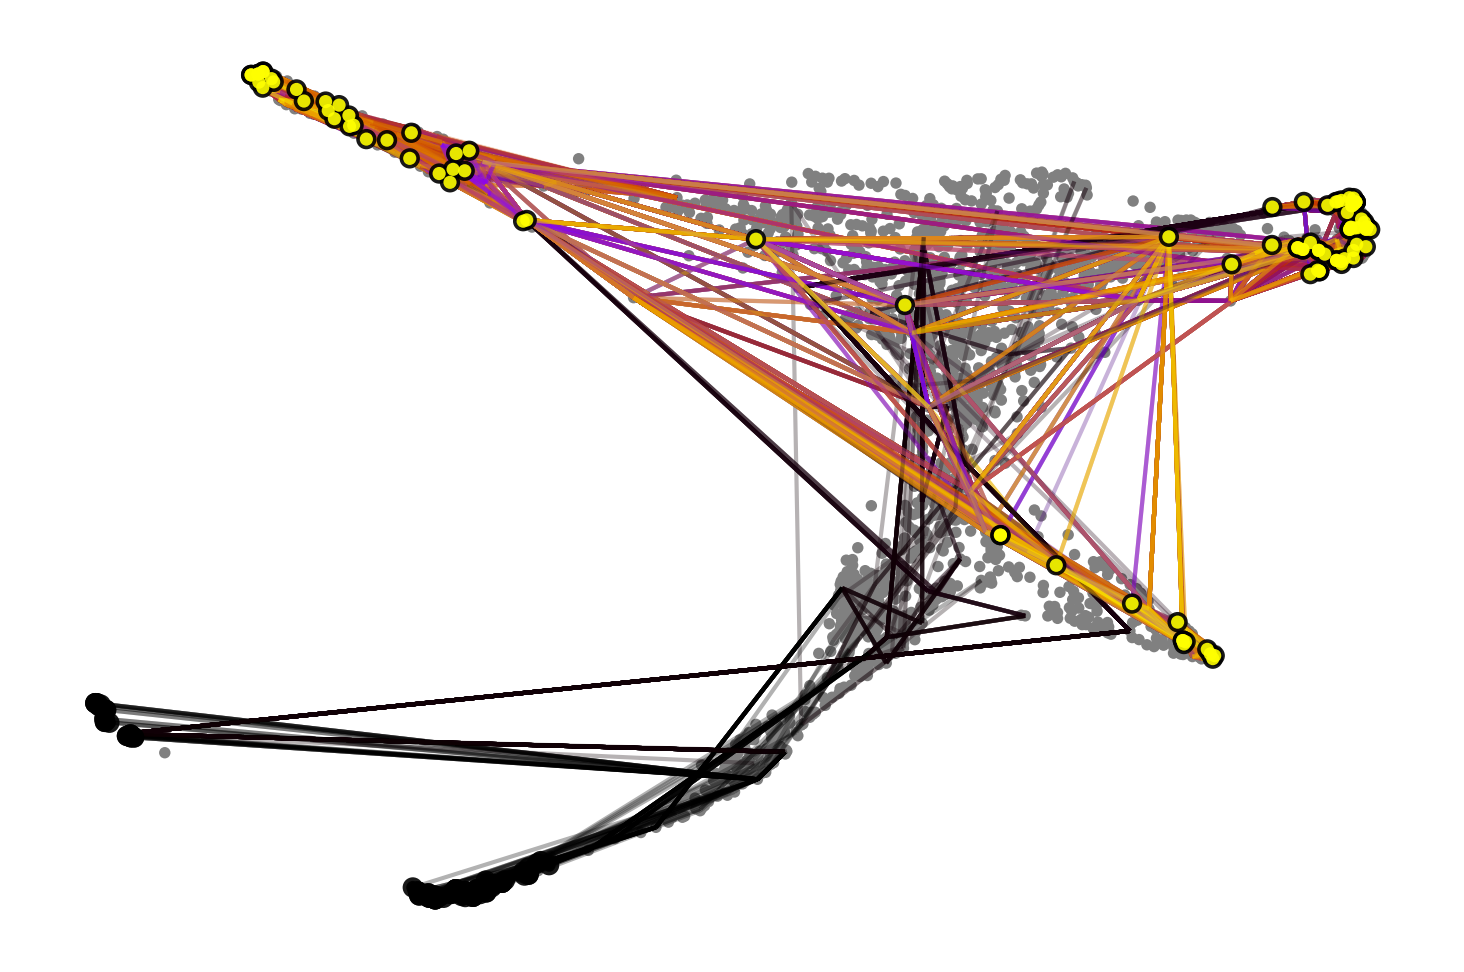

In [138]:
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"cr_timepoint": 1.5},
    basis="draw_graph_fa",
    seed=0,
    dpi=150,
    size=30,
)

Computing flow from `ICM` into `7` cluster(s) in `7` time points
Plotting flow from `ICM` into `3` cluster(s) in `7` time points


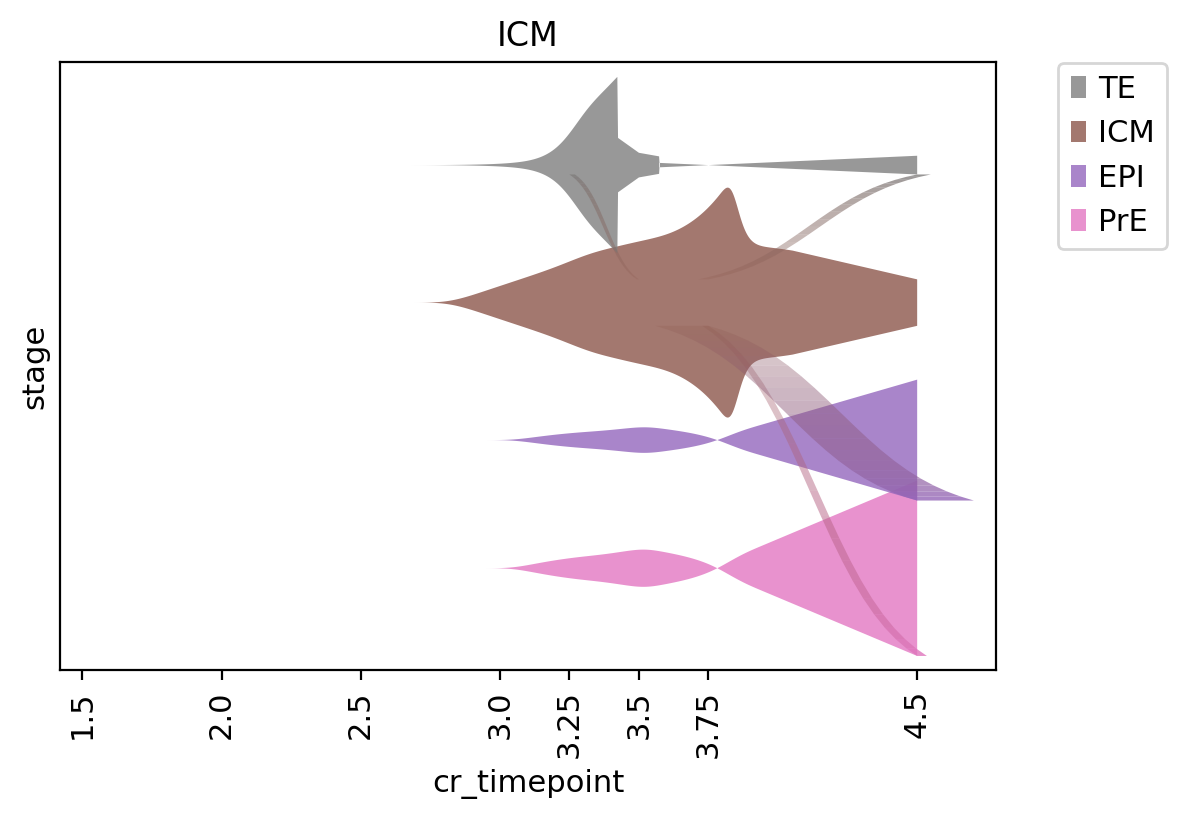

In [139]:
ax = tmk.plot_single_flow(cluster_key='stage', time_key="cr_timepoint", cluster="ICM", show=False)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.invert_xaxis()

In [140]:
g = cr.estimators.GPCCA(tmk)
g

GPCCA[kernel=RealTimeKernel[n=1986], initial_states=None, terminal_states=None]

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:10)
Calculating minChi criterion in interval `[4, 12]`
Computing `6` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


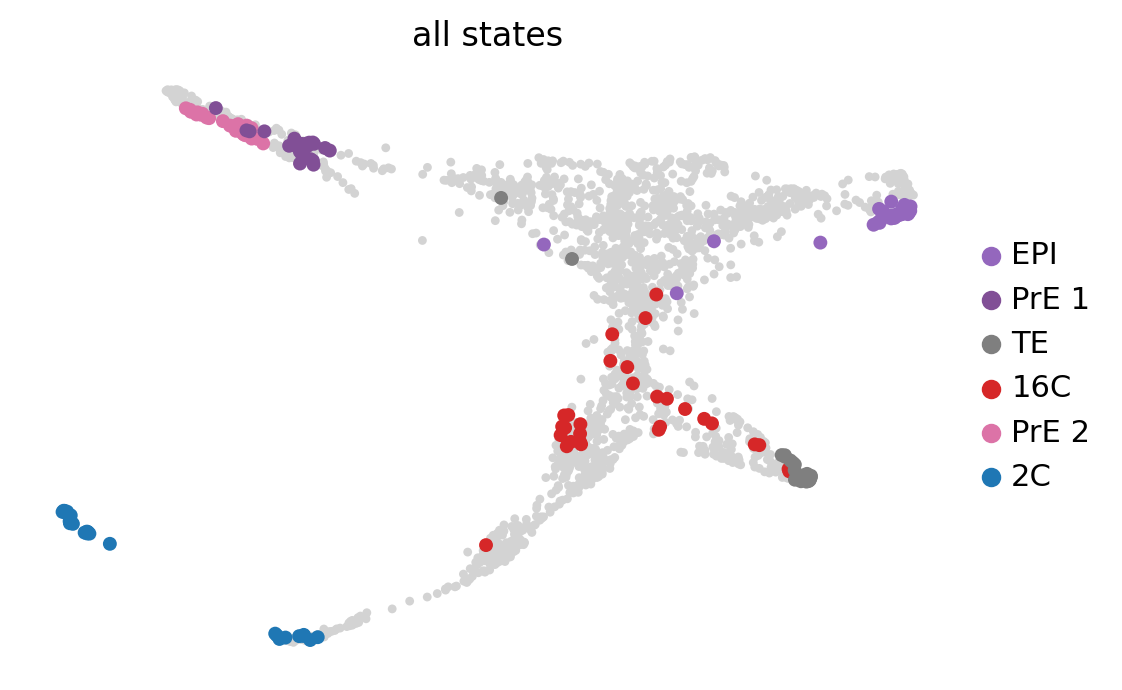

In [141]:
g.fit(cluster_key="stage", n_states=[4, 12])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100, basis='X_draw_graph_fa')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


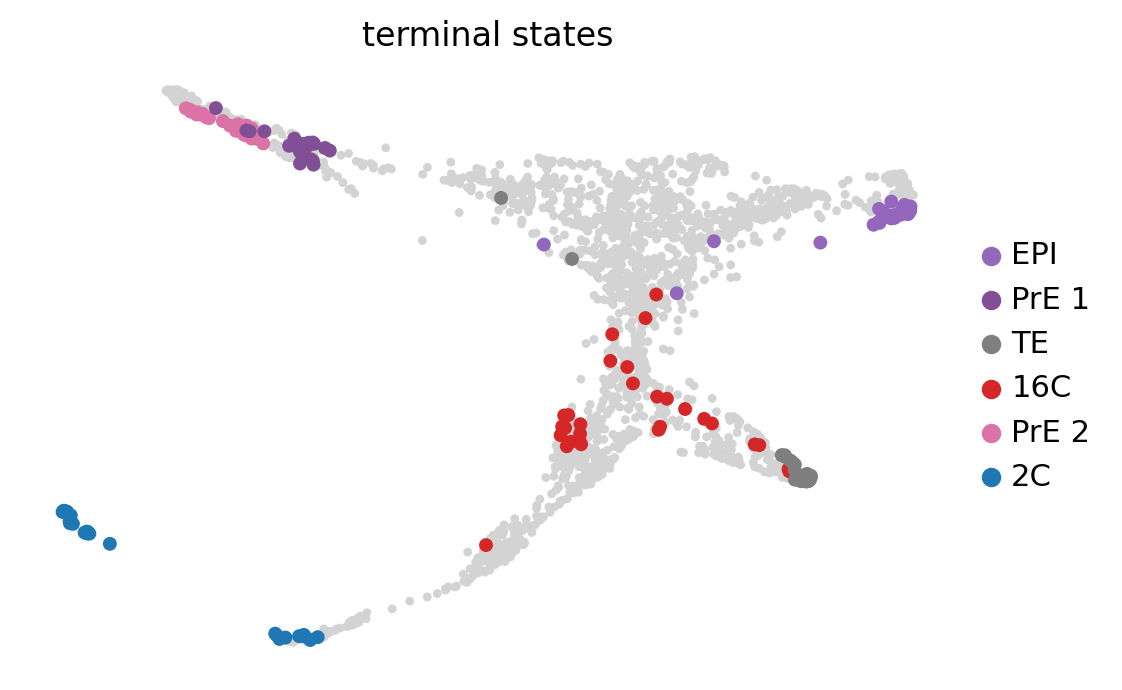

In [145]:
g.predict_terminal_states(n_states=3, allow_overlap=True)
g.plot_macrostates(which="terminal", legend_loc="right", s=100, basis='X_draw_graph_fa')

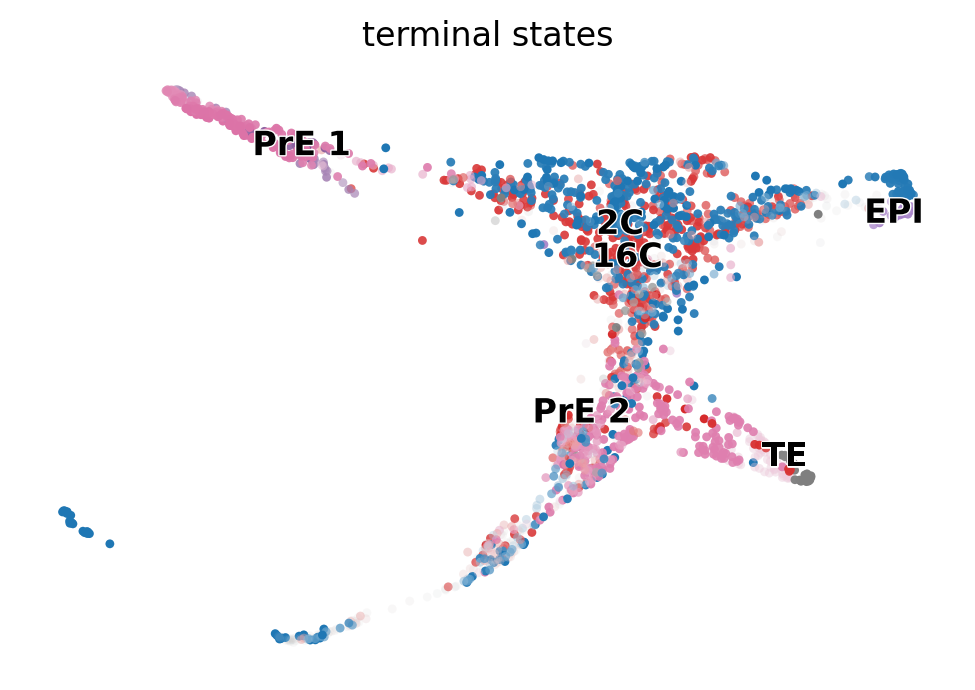

In [146]:
g.plot_macrostates(which="terminal", discrete=False, basis='X_draw_graph_fa')

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


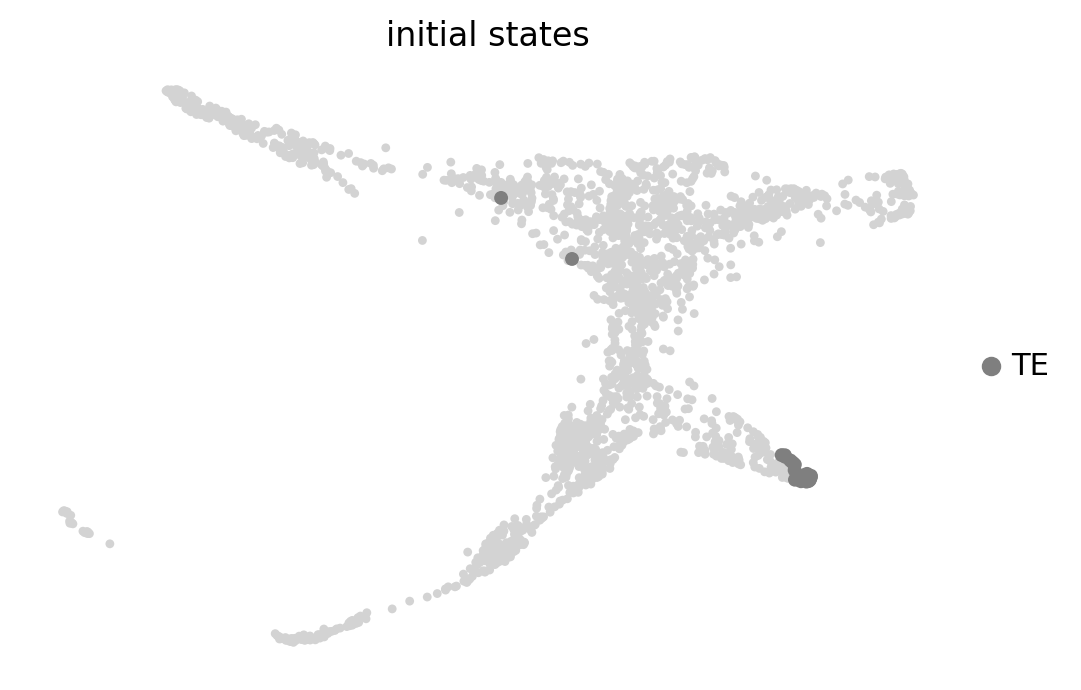

In [149]:
g.predict_initial_states(allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100, basis='X_draw_graph_fa')

## Pseudotime

In [36]:
import scvelo as scv
scv.set_figure_params('scvelo')

In [ ]:
test = scv.datasets.pancreas()
test

In [ ]:
scv.pp.filter_genes(test, min_shared_counts=20)
scv.pp.normalize_per_cell(test)
scv.pp.filter_genes_dispersion(test, n_top_genes=2000)
scv.pp.log1p(test)

In [ ]:
scv.pp.filter_and_normalize(test, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(test, n_pcs=30, n_neighbors=30)

In [ ]:
scv.tl.velocity(test)

In [ ]:
scv.tl.velocity_graph(test)

In [ ]:
test

In [ ]:
test.uns.keys()

In [ ]:
test.uns['velocity_graph']

In [ ]:
scv.pl.velocity_embedding_stream(test, basis='umap')

In [ ]:
scv.pl.velocity_graph(test, threshold=.1)

In [ ]:
scv.tl.velocity_pseudotime(test, use_velocity_graph=False)
scv.pl.scatter(test, color='velocity_pseudotime', cmap='gnuplot')

In [ ]:
test.obs.end_points

## Hack

In [37]:
# tmk.adata.obs[tmk.adata.obs.timepoint == 'E4.5'].sort_values(by='t')

In [150]:
from scvelo.tl.velocity_pseudotime import VPT
from scvelo.utils import scale
import numpy as np

In [171]:
# vpt = VPT(test)
vpt = VPT(tmk.adata)

In [172]:
vpt._transitions_sym = tmk.transition_matrix

In [173]:
vpt.compute_eigen(n_comps=10)

In [174]:
vpt.set_iroot('SRX259216')
vpt.compute_pseudotime()
dpt_root = vpt.pseudotime

In [175]:
vpt.set_iroot('Lib1-2_E4.5_CAGCTGGGTAACGCGA')
vpt.compute_pseudotime(inverse=True)
dpt_end = vpt.pseudotime

In [176]:
# merge dpt_root and inverse dpt_end together
vpt.pseudotime = np.nan_to_num(dpt_root) + np.nan_to_num(dpt_end)
vpt.pseudotime[np.isfinite(dpt_root) & np.isfinite(dpt_end)] /= 2
vpt.pseudotime = scale(vpt.pseudotime)
vpt.pseudotime[np.isnan(dpt_root) & np.isnan(dpt_end)] = np.nan

In [177]:
vpt.branchings_segments()

In [178]:
adata.obs['hack'] = 0
adata.obs.loc[tmk.adata.obs_names, 'hack'] = vpt.pseudotime

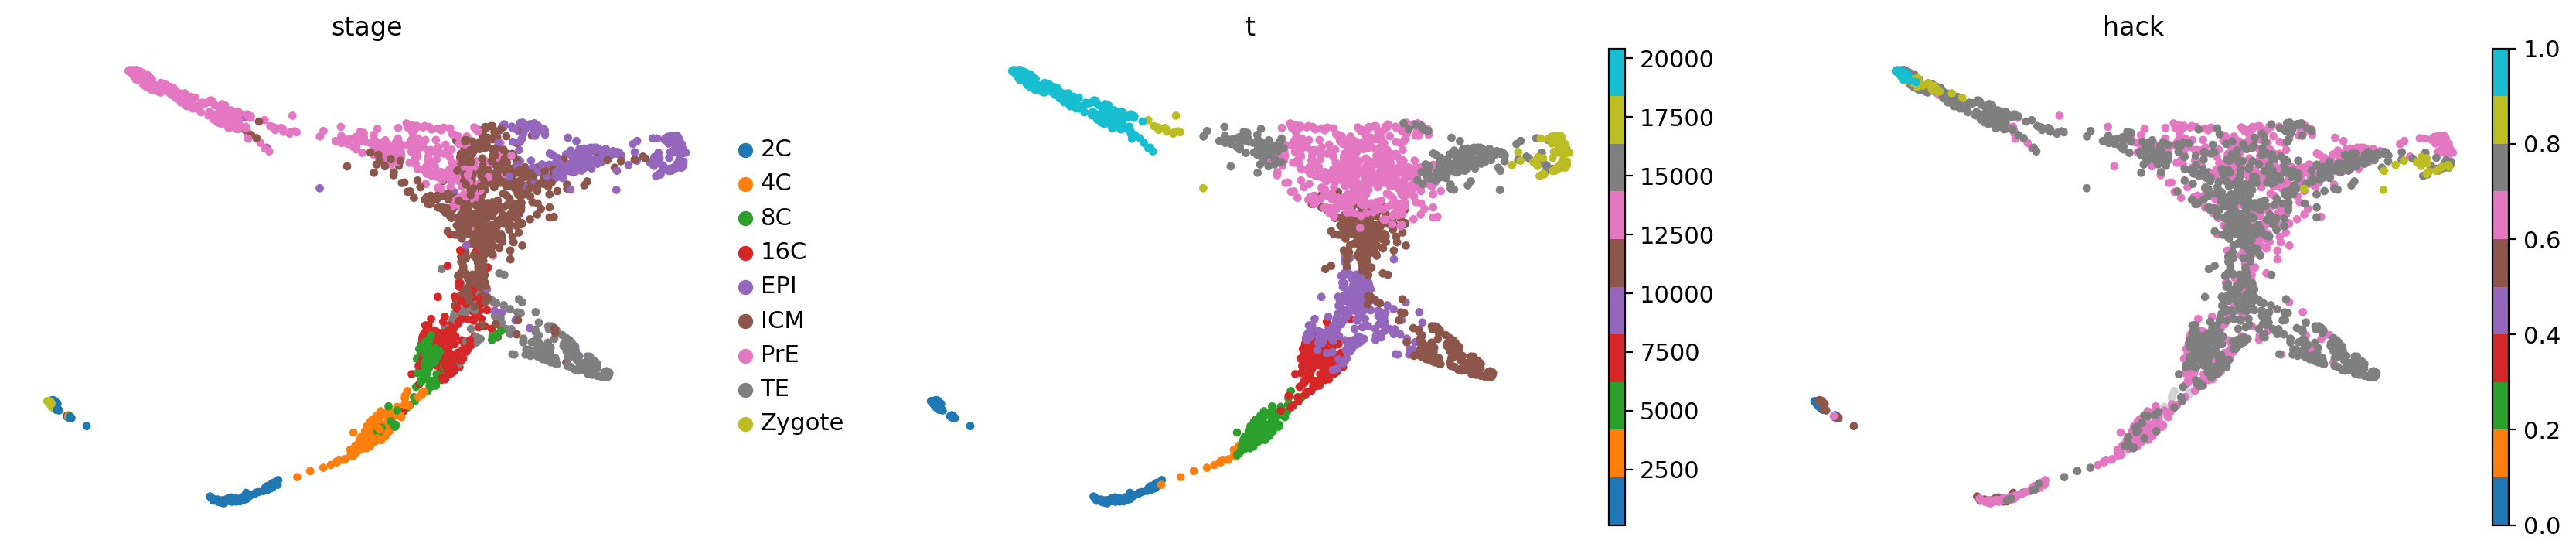

In [179]:
sc.pl.embedding(adata, basis="X_draw_graph_fa", color=["stage", "t", "hack"], cmap='tab10')

## Save session

In [ ]:
# Doesn't work
# TypeError: _write_lineage() got an unexpected keyword argument '_writer'
# Above error raised while writing key 'macrostates_fwd_memberships' of <class 'h5py._hl.group.Group'> to /

# adata.write("../results/04_mouse.cellrank.h5ad")